# Dependencies 

In [1]:
from sys import path
path.append('src/')

import numpy as np
import tensorflow as tf
import pickle as pkl
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, MaxPool2D, Dropout, BatchNormalization, Activation, UpSampling2D
from keras.utils import plot_model
from skmultilearn.model_selection import iterative_train_test_split

Using TensorFlow backend.


In [2]:
FILE_TRAIN_DUMP = 'data/train_dump.pkl'
FILE_VAL_DUMP = 'data/val_dump.pkl'

# Data Loading 

In [3]:
_, x_train, train_mrks = pkl.load(open(FILE_TRAIN_DUMP, 'rb'))
y_train = np.array([mrk_file.photo_reqs.values() for mrk_file in train_mrks])

print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)

(5211, 224, 224, 3) float32
(5211, 23) int32


In [4]:
_, x_val, val_mrks = pkl.load(open(FILE_VAL_DUMP, 'rb'))
y_val = np.array([mrk_file.photo_reqs.values() for mrk_file in val_mrks])

print(x_val.shape, x_val.dtype)
print(y_val.shape, y_val.dtype)

(571, 224, 224, 3) float32
(571, 23) int32


In [5]:
x = np.concatenate((x_train, x_val), axis=0)
y = np.concatenate((y_train, y_val), axis=0)

print(x.shape, y.shape)

(5782, 224, 224, 3) (5782, 23)


In [6]:
x_train, y_train, x_val, y_val = iterative_train_test_split(x, y, test_size=0.1)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(5188, 224, 224, 3) (5188, 23)
(594, 224, 224, 3) (594, 23)


# Model Training 

In [10]:
def conv_bn(idx, prev_input, filters):
    conv_name = 'conv_' + str(idx)
    bn_name = 'bn_' + str(idx)
    act_name = 'relu_' + str(idx)
    
    conv = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=None, name=conv_name)(prev_input)
    conv = BatchNormalization(axis=-1, name=bn_name)(conv)
    conv = Activation('relu', name=act_name)(conv)
    return conv

def conv_bn_maxpool(idx, prev_input,  filters):
    pool_name = 'pool_' + str(idx)
    
    conv = conv_bn(idx, prev_input, filters)
    pool = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name=pool_name)(conv)
    return pool

def up_conv(idx, prev_input, filters):
    up_name = str(idx) + '_up' 
    conv_name = str(idx) + '_conv' 
    
    deconv = UpSampling2D(size=(2, 2), name=up_name)(prev_input)
    deconv = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=None, name=conv_name)(deconv)
    return deconv

def up_conv_bn(idx, prev_input, filters):
    up_name = str(idx) + '_up' 
    
    deconv = UpSampling2D(size=(2, 2), name=up_name)(prev_input)
    deconv = deconv_bn(idx, deconv, filters)
    return deconv

def deconv_bn(idx, prev_input, filters):
    bn_name = str(idx) + '_bn' 
    act_name = str(idx) + '_relu' 
    conv_name = str(idx) + '_conv' 
    
    deconv = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=None, name=conv_name)(prev_input)
    deconv = BatchNormalization(axis=-1, name=bn_name)(deconv)
    deconv = Activation('relu', name=act_name)(deconv)
    return deconv

In [11]:
inputs = Input(shape=x.shape[1:])
pool_1 = conv_bn_maxpool(1, inputs, 8)
pool_2 = conv_bn_maxpool(2, pool_1, 16)
pool_3 = conv_bn_maxpool(3, pool_2, 32)
pool_4 = conv_bn_maxpool(4, pool_3, 64)
encode = conv_bn(5, pool_4, 128)

dec_4 = deconv_bn(5, encode, 64)
dec_3 = up_conv_bn(4, dec_4, 32)
dec_2 = up_conv_bn(3, dec_3, 16)
dec_1 = up_conv_bn(2, dec_2, 8)
decoded = up_conv(1, dec_1, 3)

model = Model(inputs=inputs, outputs=decoded)
model.summary()

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, x_train, batch_size=32, epochs=30, validation_data=(x_val, x_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 224, 224, 8)       224       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 224, 224, 8)       32        
_________________________________________________________________
relu_1 (Activation)          (None, 224, 224, 8)       0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 112, 112, 8)       0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 112, 112, 16)      1168      
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 112, 112, 16)      64        
__________

5188/5188 [==============================] - 10s 2ms/step - loss: 283.8024 - val_loss: 279.0710
Epoch 28/30
5188/5188 [==============================] - 10s 2ms/step - loss: 271.7064 - val_loss: 314.5358
Epoch 29/30
5188/5188 [==============================] - 10s 2ms/step - loss: 273.9701 - val_loss: 300.5540
Epoch 30/30
5188/5188 [==============================] - 10s 2ms/step - loss: 273.6529 - val_loss: 283.1748


In [23]:
y_pred = model.predict(x_val)

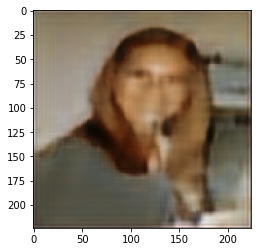

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

im = y_pred[0]
im = normalize(im).astype(np.uint8)
plt.imshow(im[:, :, ::-1])

In [26]:
def normalize(im):
    min_im, max_im = im.min(), im.max()
    return ((im - min_im) / (max_im - min_im)) * 255

In [27]:
im_norm = normalize(im)
im_norm.min(), im_norm.max()

(0.0, 255.0)